In [1]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, RGBImgObsWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from cnn import MinigridFeaturesExtractor
from stable_baselines3.common.utils import obs_as_tensor

pygame 2.5.2 (SDL 2.28.3, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
model = PPO.load("/Users/kevinroice/Documents/research/discovery/experiments/FeatAct_minigrid/models/ppo_MiniGrid-DoorKey-5x5-v0.zip") # 12 dim feats

In [3]:
import random
import os
def make_env():
    # random.seed(0)
    # np.random.seed(0)
    # os.environ['PYTHONHASHSEED'] = str(0)
    # gym.utils.seeding.np_random(0)
    env = gym.make("MiniGrid-DoorKey-5x5-v0", render_mode="rgb_array")
    env = RGBImgObsWrapper(env)
    env = ImgObsWrapper(env)
    env = Monitor(env)
    return env

def pre_process_obs(obs, model):
    obs = np.transpose(obs, (0,3,1,2)) # bring colour channel to front
    return obs_as_tensor(obs, model.policy.device)

def get_obs(env, see_obs=False):
    # # Vector Action Encoding:
    # 0 = left
    # 1 = right
    # 2 = forward
    # 3 = pickup
    # 5 = activate an object (open door, press button)

    obs_list = []
    obs = env.reset() # initial observation
    obs_list.append(obs)
    
    # move to the hallway
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)# before picking up key
    obs, _, _, _ = env.step([3])
    obs_list.append(obs)# after picking up key
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)# before opening door
    obs, _, _, _ = env.step([5])
    obs_list.append(obs)# after opening door
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)# before reaching goal
    

    
    if see_obs:
        img = env.render()
        plt.figure()
        plt.imshow(np.concatenate([img], 1)) # shows the full environment
        # plt.savefig("../../plots/feature_activations/minigrid_doorkey_5x5/s5_beforegoal.png", dpi=300)
    
    return obs_list

/Users/kevinroice/Documents/research/discovery/venv/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/kevinroice/Documents/research/discovery/venv/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_attr('height')` that will search the reminding wrappers.
  logger.warn(
/Users/kevinroice/Documents/research/discovery/venv/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do

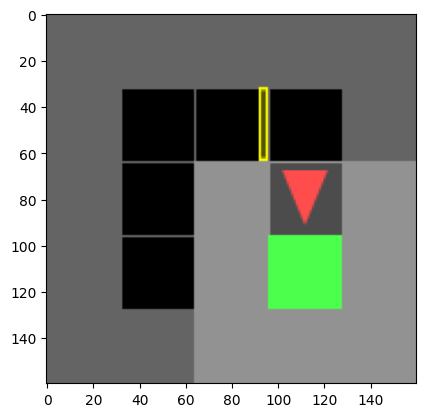

In [4]:
env = DummyVecEnv([make_env])
env.seed(0)
obs_list = get_obs(env, see_obs=True)
# obs = env.reset()
# img = env.render()
# plt.figure()
# plt.imshow(np.concatenate([img], 1)) # shows the full environment
max_feat_list = []
feature_activations = []

with torch.no_grad():
    for obs in obs_list:
        obs = pre_process_obs(obs, model)
        x = model.policy.extract_features(obs)/255
        max_feat_list.append(torch.argmax(x).item())
        feature_activations.append(x.reshape(1, -1))

feature_activations = torch.cat(feature_activations, dim=0)

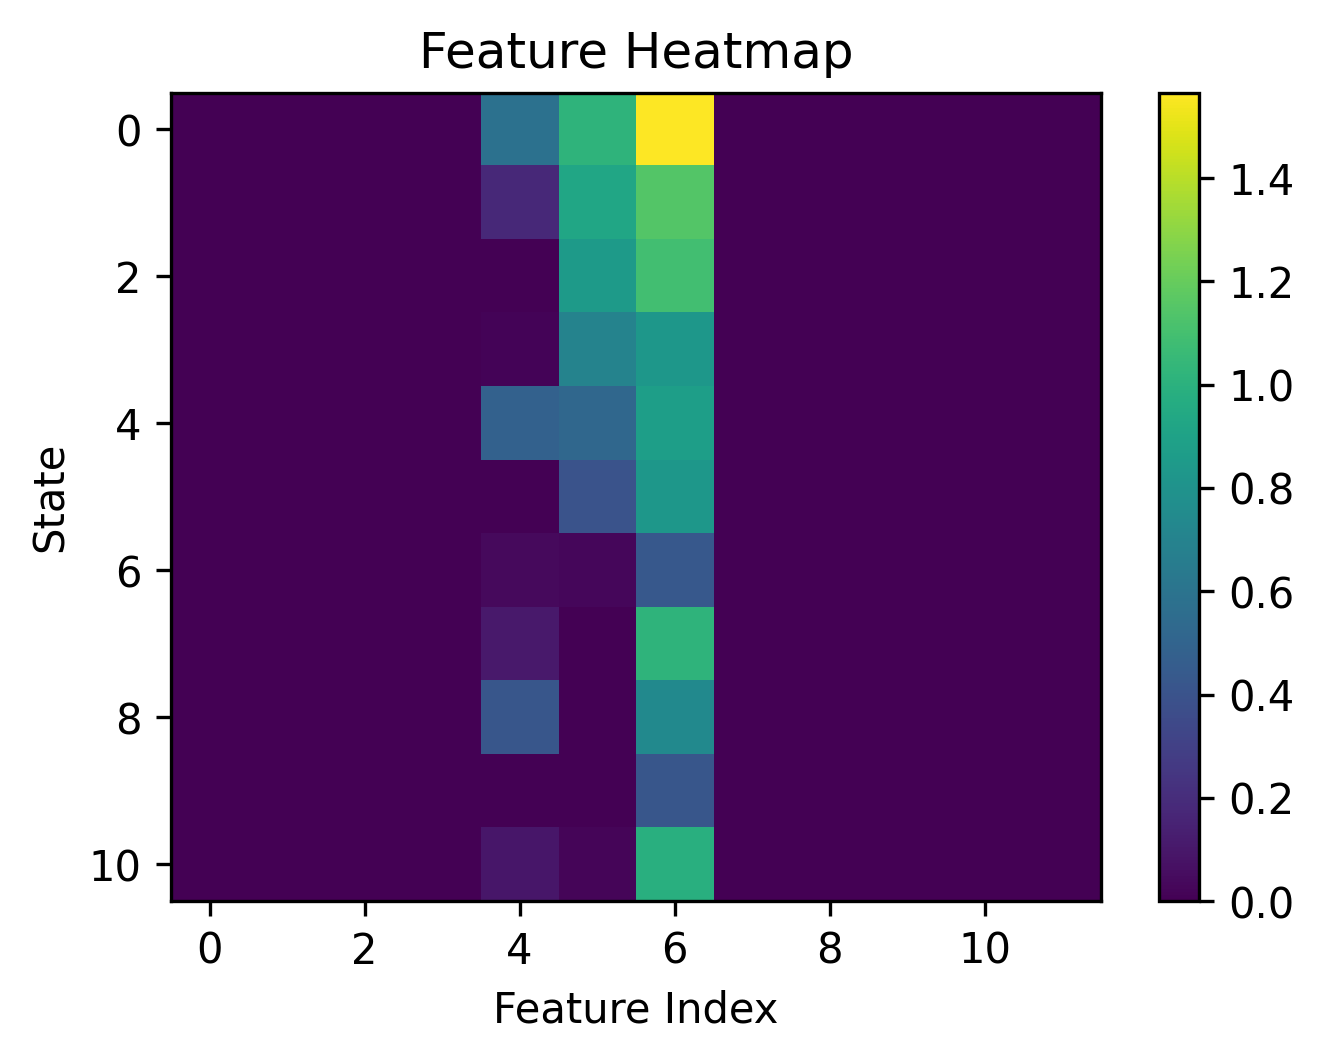

In [5]:
plt.figure(figsize=(5, 3.5), dpi=300)  # Adjust the figure size as needed
plt.imshow(feature_activations, cmap='viridis', aspect='auto')
# y_tick_positions = [i * 56 for i in range(785 // 56)] # 16 by 16
# y_tick_positions = [i * 3 for i in range(9 // 3)]
# plt.yticks(y_tick_positions)
# for y in y_tick_positions:
    # plt.axhline(y=y-0.5, linewidth=1, color='white', alpha=0.5)
plt.colorbar()
# plt.clim(0, 1)
plt.xlabel('Feature Index')
plt.ylabel('State')
plt.title('Feature Heatmap')
plt.savefig('../../plots/feature_activations/minigrid_doorkey_5x5/feature_heatmap.pdf', bbox_inches='tight')


* In this env we see there is clearly a door feature.

This makes sense: the agent cannot reach the door unless it piucksup the key first, so we shouldnt expect a key feature to arise.

We should now try this in a bigger env, where it is possible for the agent to reach the door without picking up the key. 